In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

In [2]:
cfg = breaching.get_config(overrides=["case=4_fedavg_small_scale", "case/data=CIFAR10"])

device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')  # f'cuda:2'
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

c:\Users\ricev\.conda\envs\gradientinversionattack\lib\site-packages\breaching\__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case fedavg_small_scale with server type honest_but_curious.


{'device': device(type='cuda'), 'dtype': torch.float32}

In [3]:
cfg.case.data.partition="random"
cfg.case.user.user_idx = 1
cfg.case.model='resnet50'  

cfg.case.user.provide_labels = True

# These settings govern the total amount of user data and how it is used over multiple local update steps:
cfg.case.user.num_data_points = 4
cfg.case.user.num_local_updates = 4
cfg.case.user.num_data_per_local_update_step = 2


# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 1e-3


### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture resnet50 loaded with 23,520,842 parameters and 53,173 buffers.
Overall this is a data ratio of    1914:1 for target shape [4, 3, 32, 32] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
    Local FL Setup:
        Number of local update steps: 4
        Data per local update step: 2
        Local learning rate: 0.001

        Threat model:
        Share these hyperparams to server: True

        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet50
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type Optimiz

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 1 in model mode: eval.


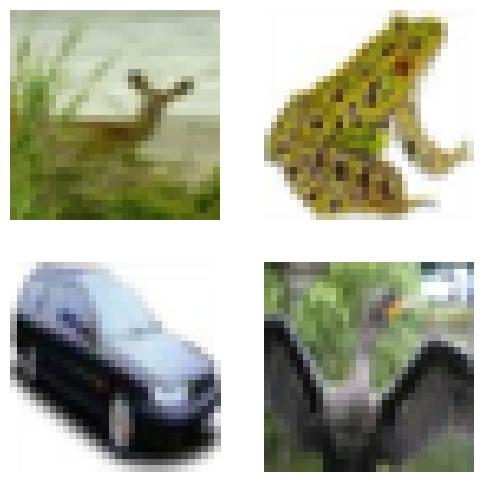

In [6]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 0.1456 |  Task loss: 0.8045 | T: 15.82s
| It: 1001 | Rec. loss: 0.0543 |  Task loss: 0.9262 | T: 13879.77s
| It: 2001 | Rec. loss: 0.0557 |  Task loss: 0.9216 | T: 13718.56s
| It: 3001 | Rec. loss: 0.0454 |  Task loss: 0.9017 | T: 13722.21s
| It: 4001 | Rec. loss: 0.0461 |  Task loss: 0.8832 | T: 13733.12s
| It: 5001 | Rec. loss: 0.0528 |  Task loss: 0.9083 | T: 13763.18s
| It: 6001 | Rec. loss: 0.0614 |  Task loss: 0.8773 | T: 13752.29s
| It: 7001 | Rec. loss: 0.0502 |  Task loss: 0.8785 | T: 13750.58s
| It: 8001 | Rec. loss: 0.0489 |  Task loss: 0.8602 | T: 13782.71s
| It: 9001 | Rec. loss: 0.0527 |  Task loss: 0.8724 | T: 13802.77s
| It: 10001 | Rec. loss: 0.0466 |  Task loss: 0.9435 | T: 13817.52s
| It: 11001 | Rec. loss: 0.0432 |  Task loss: 0.9489 | T: 13805.33s
| It: 12001 | Rec. loss: 0.0440 |  Task loss: 0.9464 | T: 13809.30s
Recovery interrupted manually in iteration 12310!
Optimal candidate solution with rec. loss 0.0346 selected.


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [8]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

c:\Users\ricev\.conda\envs\gradientinversionattack\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\ricev\.conda\envs\gradientinversionattack\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\ricev/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

c:\Users\ricev\.conda\envs\gradientinversionattack\lib\site-packages\breaching\analysis\metrics.py:24: UserWarning: To utilize wavelet SSIM, install pytorch wavelets from https://github.com/fbcotter/pytorch_wavelets.
  warnings.warn(


Files already downloaded and verified
METRICS: | MSE: 0.1324 | PSNR: 9.54 | FMSE: 1.7024e+00 | LPIPS: 0.17|
 R-PSNR: 10.12 | IIP-pixel: 0.00% | SSIM: nan | max R-PSNR: 13.16 | max SSIM: nan | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

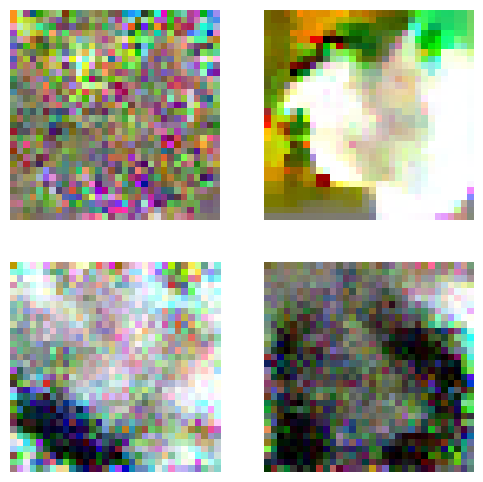

In [9]:
user.plot(reconstructed_user_data)

### Notes:
* If labels are unknown, then a robust label recovery algorithm has to be used that does not count label repetitions due to shifts after local updates.